# Simulation and EM Maximization of the 1D Simple Likelihood for scRNA-seq

In this exercise, I generate some data that (could) look like RNA seq in 1 dimension under some assumptions, and design a likelihood function that could recover (some) parameters.

I describe an EM-like optimization algorithm to approximately maximize this objective.

This notebook contains the groundwork and simulation for modeling the latent variables as a log normal distribution, rather than the normal distribution that I attempted first.

### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time

In [3]:
MAX_LATENT = 200

### Function for fitting a weighted lognormal distribution

In [4]:
def fit_lognormal(x, w=None, neg_mean=False):
    
    if neg_mean:

        x = np.concatenate([
            np.random.uniform(high=0.5, size=500),
            x[1:]])
        w = np.concatenate([
            w[0]/500 * np.ones(500),
            w[1:]])
    
    lnx = np.log(x[x > 0])
    muhat = np.average(lnx, weights=w[x > 0])
    varhat = np.average((lnx - muhat)**2, weights=w[x > 0])
    
    return muhat, np.sqrt(varhat)

### Simulation - UPDATE FOR LOG NORMAL

Let us simulate a possible procedure for generadting scRNA-seq data in 1 dimension (1 gene case).


1. The underlying distribution Z is mean $\mu$ with variance $\sigma^{2}$, $Z \sim \mathcal{N}(\mu,\,\sigma^{2})\,.
$
2. Then, for each cell sampled from this distribution, we round to the nearest integer and sample a binomial random variable X distributed as $X \sim Bn(round(Z), p)$ where the sampled $Z$ serves as the number of trials and $p$ serves as the dropout rate of an individual transcript in a cell.

For this simulation, we use:
- $N$ = 100,000
- $\mu$ = 3
- $\sigma$ = 1
- $p$ = 0.1

minimum parameters

num_cells = 1000
s = .6
scale = 1.5
p=0.1


In [61]:
# Parameters
num_cells = 20000

mu = 1
sigma = 1.5
p=0.05

s = sigma
scale = np.exp(mu)


In [62]:
print(s, scale)

1.5 2.718281828459045


In [63]:
continuous = stats.lognorm.rvs(s=s, scale=scale, size=num_cells)
normal_continuous = stats.norm.rvs(loc=np.log(scale), scale=s, size=num_cells)

In [64]:
ground_truth_counts = np.round(continuous).astype(np.int64)

In [65]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

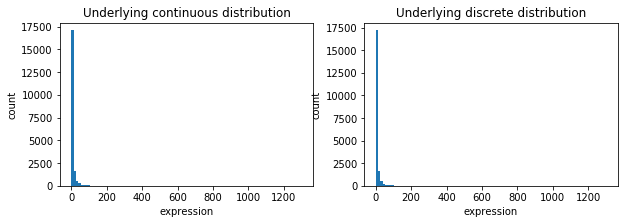

In [66]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
plt.title('Underlying continuous distribution')
plt.hist(continuous, bins=100);
plt.xlabel('expression');plt.ylabel('count')
#plt.xlim(0, 25)
plt.subplot(1, 2, 2);
plt.title('Underlying discrete distribution')
plt.xlabel('expression'); plt.ylabel('count')
plt.hist(ground_truth_counts, bins=100);
#plt.xlim(0, 25)

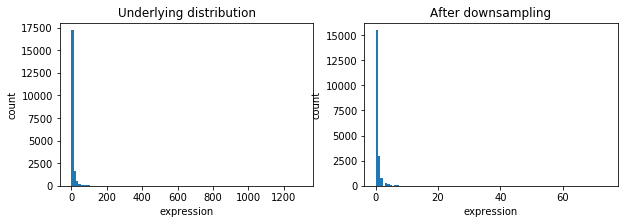

In [67]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1);
plt.title('Underlying distribution')
plt.hist(ground_truth_counts, bins=100);
plt.xlabel('expression');plt.ylabel('count');
plt.subplot(1, 2, 2);
plt.title('After downsampling')
plt.xlabel('expression'); plt.ylabel('count');
plt.hist(observed, bins=100);
#plt.xlim(0, 10)

In [72]:
p_hat = 0.01

In [73]:
mu_hat_closed = np.log(observed.mean()) - np.log(p_hat) - (1/2)*np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1)

In [74]:
sigma_hat_closed = np.sqrt(np.log(observed.var()/observed.mean()**2 - (1-p_hat)/observed.mean() + 1))

In [75]:
print(mu_hat_closed, sigma_hat_closed)

2.575286741515015 1.526043669852553


### Expectation step: Computing probabilities for Z

The expectation step of the EM algorithm involves calculating the probability of each possible value of Z the hidden variable (in our case, the true expression) given the parameters and the observations (X, mu, sigma, and p).

We use the Bayes rule to construct our probabilites for the hidden variables:

$ P(Z | X) = \frac{P(X|Z)P(Z)}{P(X)} $

Because of our distributional assumptions, we can evaluate each of the values on the RHS given p, mu, and sigma:

$
P(X|Z) = {z\choose{x}}p^{x}(1-p)^{z-x} \\
P(Z) = \frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big) \\
P(X) = \sum_{z=0}^{\infty} \bigg[{z\choose{x}}p^{x}(1-p)^{z-x}\bigg]\bigg[\frac{1}{\sqrt{2\pi\sigma^{2}}} \exp\big(-\frac{(z-\mu)^{2}}{2\sigma^{2}}\big)\bigg]
$

In [38]:
binom_table = np.zeros(shape=(MAX_LATENT, MAX_LATENT))
    
for x in range(MAX_LATENT):
    for z in range(x, MAX_LATENT):
        binom_table[x, z] = stats.binom.pmf(x, z, p)

In [39]:
def rv_pmf(x, mu, sigma):
    """ PDF/PMF of the random variable under use. """
    
    return stats.lognorm.cdf(0.5, s=sigma, loc=0, scale=np.exp(mu))*(x==0) + \
        (stats.lognorm.cdf(x+0.5, s=sigma, loc=0, scale=np.exp(mu)) - stats.lognorm.cdf(x-0.5, s=sigma, loc=0, scale=np.exp(mu)))*(x!=0)

In [40]:
# def create_px_table_old(mu, sigma, p):
#     return np.array([
#         (rv_pmf(np.arange(x, MAX_LATENT), mu, sigma) * stats.binom.pmf(x, np.arange(x, MAX_LATENT), p)).sum()
#         for x in range(MAX_LATENT)])

In [41]:
def create_px_table(mu, sigma, p):
    
    z_probs = np.tile(rv_pmf(np.arange(0, MAX_LATENT), mu, sigma).reshape(1, -1), [MAX_LATENT, 1])
    
    return (z_probs * binom_table).sum(axis=1)

In [42]:
# def create_pz_table(mu, sigma, p):
#     """ Returns a matrix M x M where rows indicate X and columns indicate Z """
    
#     px_table = create_px_table(mu, sigma, p)
#     #px_table = np.tile(px_table.reshape(-1, 1), [1, MAX_LATENT])
    
#     #z_probs = np.tile(rv_pmf(np.arange(0, MAX_LATENT), 5, 3).reshape(1, -1), [MAX_LATENT, 1])
    
#     table = np.zeros((MAX_LATENT, MAX_LATENT))
    
#     for x in range(MAX_LATENT):
#         for z in range(x, MAX_LATENT):
#             table[x, z] = rv_pmf(z, mu, sigma) * stats.binom.pmf(x, z, p) / px_table[x]
#     return table

In [43]:
def create_pz_table(mu, sigma, p, px_table):
    """ Returns a matrix M x M where rows indicate X and columns indicate Z """
    
    #px_table = create_px_table(mu, sigma, p)
    px_table = np.tile(px_table.reshape(-1, 1), [1, MAX_LATENT])
    
    z_probs = np.tile(rv_pmf(np.arange(0, MAX_LATENT), mu, sigma).reshape(1, -1), [MAX_LATENT, 1])
    
    table = z_probs * binom_table / px_table

    return table

In [44]:
def log_likelihood(observed, mu, sigma):
    
    observed_counts = pd.Series(observed).value_counts()
    optimal_px_table = create_px_table(mu, sigma, 0.1)
    optimal_likelihood = np.array([count*np.log(optimal_px_table[val]) for val,count in zip(observed_counts.index, observed_counts)]).sum()
    optimal_likelihood

### Maximization step: Fit a weighted Gaussian on the latent variables

The maximization step in the EM algorithm involves using the calculated values of $P(Z|X)$ above to fit new values of the parameters mu, sigma, and p.

In the 1D case, this is rather simple: we expand out each observation $ X = i $ to ~30 different values with different weights. For example, if we observed a cell with $ X = 1 $, we create 20 rows for this cell with different values of Z that it could have had. Then, we fit a Gaussian (calculate mean and variance) on those Z values, with using the previously calculated $P(Z|X)$ as weights. More concretely, we calculate the mean and variance as follows, when we consider the upper limit of $Z$ to be $Z_{max}$:

$
\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z)    \big]\bigg) \\
\hat{\sigma}^2 = \frac{1}{N-1}\sum_{i=1}^{N}\bigg( \sum_{z=x_i}^{Z_{max}}\big[ P(z|x_i)(z - \hat{\mu})^2 \big]\bigg)
$

In [45]:
def get_parameters(observed_data, prob_table, base_dataframe):
    """ Get the parameters of the Gaussian and dropout """
    
    weights = np.triu(prob_table+1, k=0).reshape(-1)
    weights = weights[weights != 0] -1
    
    observed_data['latent_weight'] = weights[observed_data['row_num'].values]
    
#     base_dataframe['latent_weight'] = np.concatenate([prob_table[x, x:].reshape(-1, 1) for x in range(MAX_LATENT)])
    
#     data = observed_data.join(
#         base_dataframe,
#         how='left')
    
    observed_data['point_weight'] = observed_data['observed_weight'] * observed_data['latent_weight']
    
    p_estimate = p
    mu, sigma = fit_lognormal(observed_data['latent'].values, w=observed_data['point_weight'].values)
    
    return mu, sigma, p_estimate

### Perform EM

In [46]:
# Initialize hyperparameters for EM
NUM_ITER = 500

In [47]:
# Initialize the parameters
p_hat = p
mu_hat = 10
sigma_hat = 10

In [48]:
observed_counts = pd.Series(observed).value_counts()
neg_mean = neg_mean = (observed_counts[0]/observed_counts.sum() > (1-p))

In [49]:
data = pd.DataFrame()
data['observed'] = observed
data = data.groupby('observed').size().reset_index(name='count')
data['observed_weight'] = data['count'] / len(observed)
data.set_index('observed', inplace=True)

In [50]:
base_dataframe = pd.concat(
    [pd.DataFrame(
        np.concatenate(
            [np.ones(MAX_LATENT-x).reshape(-1, 1)*x, 
            np.arange(x, MAX_LATENT).reshape(-1,1)], axis=1), 
        columns=['observed', 'latent']) for x in range(MAX_LATENT)])
base_dataframe.set_index('observed', inplace=True)
base_dataframe['row_num'] = np.arange(base_dataframe.shape[0])

In [51]:
data = data.join(
    base_dataframe,
    how='left') 

In [52]:
data.shape

(1759, 4)

In [53]:
fitting_progress = []
start = time.time()
for itr in range(NUM_ITER):
    
    px_table = create_px_table(mu_hat, sigma_hat, p)
    likelihood = np.array([count*np.log(px_table[val]) for val,count in zip(observed_counts.index, observed_counts)]).sum()
    
    if itr > 0 and (likelihood < fitting_progress[-1][4] + 1e-2 or np.isnan(mu_hat) or np.isnan(sigma_hat) or np.isnan(likelihood)):
        mu_hat = fitting_progress[-1][1]
        sigma_hat = fitting_progress[-1][2]
        print("stopped")
        break
    
    fitting_progress.append((itr, mu_hat, sigma_hat, p_hat, likelihood))
    
    # E step
    prob_table = create_pz_table(mu_hat, sigma_hat, p_hat, px_table)
    # M step
    mu_hat, sigma_hat, p_hat = get_parameters(data, prob_table, base_dataframe)
print('runtime:', time.time() - start)

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


stopped
runtime: 0.28125619888305664


In [54]:
fitting_progress = pd.DataFrame(fitting_progress, columns=['iteration', 'mu_hat', 'sigma_hat', 'p_hat', 'log_likelihood'])

In [55]:
optimal_px_table = create_px_table(mu, sigma, p)
optimal_likelihood = np.array([count*np.log(optimal_px_table[val]) for val,count in zip(observed_counts.index, observed_counts)]).sum()
optimal_likelihood

-5720.43932390851

In [56]:
fitting_progress.tail(5)

,iteration,mu_hat,sigma_hat,p_hat,log_likelihood
59,59,1.785583,0.860307,0.01,-5792.480863
60,60,1.785441,0.860302,0.01,-5792.467156
61,61,1.785310,0.860296,0.01,-5792.454526
62,62,1.785190,0.860292,0.01,-5792.442889
63,63,1.785079,0.860288,0.01,-5792.432167


In [57]:
print(mu, sigma)

1 1.5


Text(0.5,1,'log-likelihood')

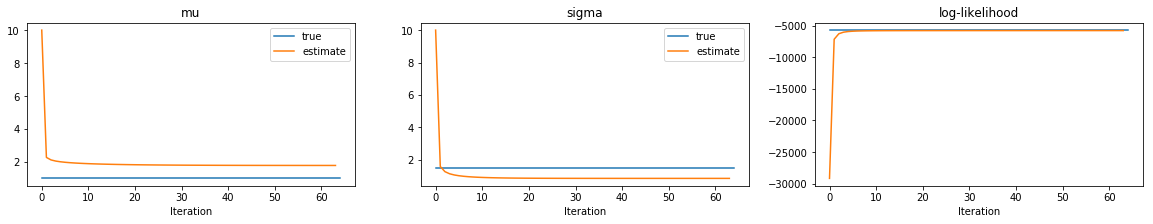

In [58]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
plt.plot([0, itr], [mu, mu])
plt.plot(fitting_progress.iteration, fitting_progress.mu_hat)
plt.xlabel('Iteration'); plt.legend(['true', 'estimate']); plt.title('mu')

plt.subplot(1, 3, 2)
plt.plot([0, itr], [sigma, sigma])
plt.plot(fitting_progress.iteration, fitting_progress.sigma_hat)
plt.xlabel('Iteration'); plt.legend(['true', 'estimate']); plt.title('sigma')

plt.subplot(1, 3, 3)
plt.plot([0, itr], [optimal_likelihood, optimal_likelihood])
plt.plot(fitting_progress.iteration, fitting_progress.log_likelihood)
plt.xlabel('Iteration'); plt.title('log-likelihood')
#plt.ylim(-1050, -1040)

### Re-create the original distribution

Sample a Log-normal distribution with the estimated parameters.

In [76]:
reconstructed_counts = np.clip(
    np.round(stats.lognorm.rvs(
        s=sigma_hat,
        scale=np.exp(mu_hat), 
        size=num_cells) ),
    a_min=0, 
    a_max=1000).astype(np.int64)

reconstructed_counts_closed = np.clip(
    np.round(stats.lognorm.rvs(
        s=sigma_hat_closed,
        scale=np.exp(mu_hat_closed), 
        size=num_cells) ),
    a_min=0, 
    a_max=1000).astype(np.int64)

reconstructed_normal = stats.norm.rvs(
    loc=mu_hat, 
    scale=sigma_hat, size=num_cells)

reconstructed_normal_closed = stats.norm.rvs(
    loc=mu_hat_closed, 
    scale=sigma_hat_closed, size=num_cells)

reconstructed_observed =  np.random.binomial(n=reconstructed_counts, p=p)
reconstructed_observed_closed =  np.random.binomial(n=reconstructed_counts_closed, p=p)

(0, 10)

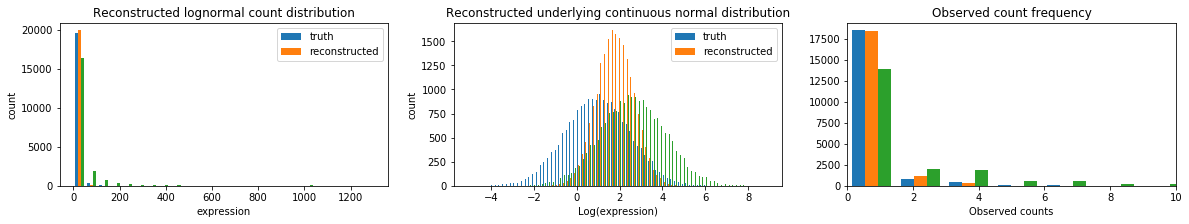

In [80]:
plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1);
plt.hist([ground_truth_counts, reconstructed_counts, reconstructed_counts_closed], bins=25);
plt.xlabel('expression');plt.ylabel('count'); plt.legend(['truth', 'reconstructed']);
plt.title('Reconstructed lognormal count distribution');

plt.subplot(1, 3, 2);
plt.hist([normal_continuous, reconstructed_normal, reconstructed_normal_closed], bins=80);
plt.xlabel('Log(expression)');plt.ylabel('count'); plt.legend(['truth', 'reconstructed'])
plt.title('Reconstructed underlying continuous normal distribution');

plt.subplot(1, 3, 3);
plt.hist([observed, reconstructed_observed, reconstructed_observed_closed], bins=50);
plt.xlabel('Observed counts')
plt.title('Observed count frequency')
plt.xlim(0, 10)

### Naive approach - multiply by 10 and pseudobulking

In [124]:
naive_mean_1 = np.nan_to_num(np.log(((1/p)*observed+1))).mean()
naive_std_1 = np.nan_to_num(np.log(((1/p)*observed+1))).std()
print('Naive mean 1:', naive_mean_1)
print('Naive std 1:', naive_std_1)

Naive mean 1: 0.19601922014279366
Naive std 1: 0.9433053043894224


In [125]:
num_pbulk = 20000
pbulks = np.array([np.random.choice(observed, size=int((1/p))).sum() for i in range(num_pbulk)])
log_pbulks = np.log(pbulks+1)
print('pbulk mean:', log_pbulks.mean())
print('pbulk std:', log_pbulks.std())

pbulk mean: 1.6703718057795516
pbulk std: 0.4848434350326106


In [126]:
print(mu, sigma)

0.5 1.5


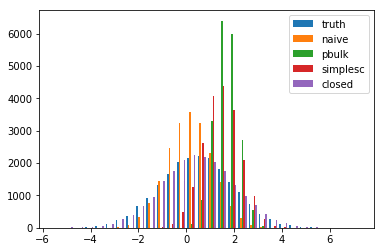

In [127]:
plt.hist([
    normal_continuous,
    stats.norm.rvs(scale=naive_std_1, loc=naive_mean_1, size=num_cells),
    stats.norm.rvs(scale=log_pbulks.std(), loc=log_pbulks.mean(), size=num_cells),
    stats.norm.rvs(scale=sigma_hat, loc=mu_hat, size=num_cells),
    stats.norm.rvs(scale=sigma_hat_closed, loc=mu_hat_closed, size=num_cells)
    ], bins=30);
plt.legend(['truth', 'naive', 'pbulk', 'simplesc', 'closed'])

### Fine tune the parameters

In [188]:
grid_size = 20
mus = np.linspace(0.05, mu_hat+0.2, grid_size)
sigmas = np.linspace(0.05, sigma_hat+0.2, grid_size)

In [189]:
lls = np.zeros((grid_size, grid_size))
for idx1, point_mu in enumerate(mus):
    for idx2, point_sigma in enumerate(sigmas):
        optimal_px_table = create_px_table(point_mu, point_sigma, p)
        optimal_likelihood = np.array([count*np.log(optimal_px_table[val]) for val,count in zip(observed_counts.index, observed_counts)]).sum()
        lls[idx1][idx2] = optimal_likelihood
        

/anaconda3/envs/scvi/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


In [190]:
lls.max()

-101886.43385522695

In [191]:
print(
    mus[np.unravel_index(np.argmax(lls), lls.shape)[0]],
    sigmas[np.unravel_index(np.argmax(lls), lls.shape)[1]])

1.5078986526790061 0.693634287192205


In [192]:
#mu_hat, sigma_hat = mus[np.unravel_index(np.argmax(lls), lls.shape)[0]], sigmas[np.unravel_index(np.argmax(lls), lls.shape)[1]]

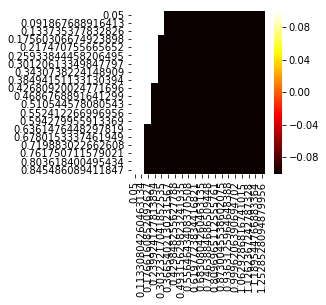

In [161]:
plt.figure(figsize=(3, 3))
sns.heatmap(lls, xticklabels=mus, yticklabels=sigmas, cmap='hot')